# TASK 1: Understanding the Limitations of RNNs and the Need for Transformers

In [7]:
import tensorflow as tf
import numpy as np
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

texts = [
    #Weather
    "it's raining outside",
    "the sun is shining brightly",
    "today is a cold day",
    "the weather is nice and warm",
    "I love snow in the winter",
    "there is a storm coming",

    #Work
    "I have a lot of work to do",
    "my boss is very strict",
    "I'm preparing for the exam",
    "I learned a lot in class today",
    "she got a new job last week",
    "we are working on a new project",

    #Emotions
    "I feel very happy today",
    "he is always sad and quiet",
    "I'm excited about tomorrow",
    "sometimes I feel lonely",
    "she was angry for no reason",
    "I'm nervous about the interview"
]

labels = [
    0, 0, 0, 0, 0, 0,     
    1, 1, 1, 1, 1, 1,      
    2, 2, 2, 2, 2, 2       
]



tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_seq_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_seq_len, padding='post')
y = np.array(labels)
vocab_size = len(tokenizer.word_index) + 1


def build_rnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 32, input_length=max_seq_len),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(3, activation='softmax') #3 classes
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.dropout2 = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))


def build_transformer_model():
    inputs = tf.keras.layers.Input(shape=(max_seq_len,))
    x = tf.keras.layers.Embedding(vocab_size, 32)(inputs)
    x = TransformerBlock(32, num_heads=2, ff_dim=64)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x) #3 classes
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# === RNN ===
rnn_model = build_rnn_model()
start_time = time.time()
rnn_model.fit(X, y, epochs=10, verbose=0)
rnn_time = time.time() - start_time
rnn_loss, rnn_acc = rnn_model.evaluate(X, y, verbose=0)

# === Transformer ===
transformer_model = build_transformer_model()
start_time = time.time()
transformer_model.fit(X, y, epochs=10, verbose=0)
transformer_time = time.time() - start_time
transformer_loss, transformer_acc = transformer_model.evaluate(X, y, verbose=0)


print(f"RNN: Time = {rnn_time:.2f}s, Loss = {rnn_loss:.4f}, Accuracy = {rnn_acc:.4f}")
print(f"Transformer: Time = {transformer_time:.2f}s, Loss = {transformer_loss:.4f}, Accuracy = {transformer_acc:.4f}")


RNN: Time = 2.21s, Loss = 1.0718, Accuracy = 0.8889
Transformer: Time = 7.20s, Loss = 0.5174, Accuracy = 0.9444


# TASK 2: Self-Attention Mechanism

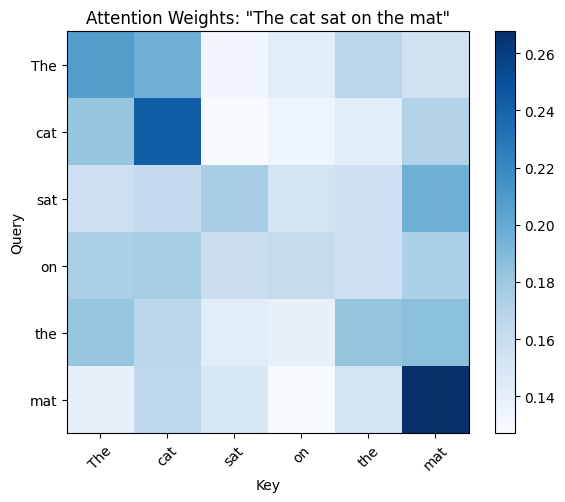

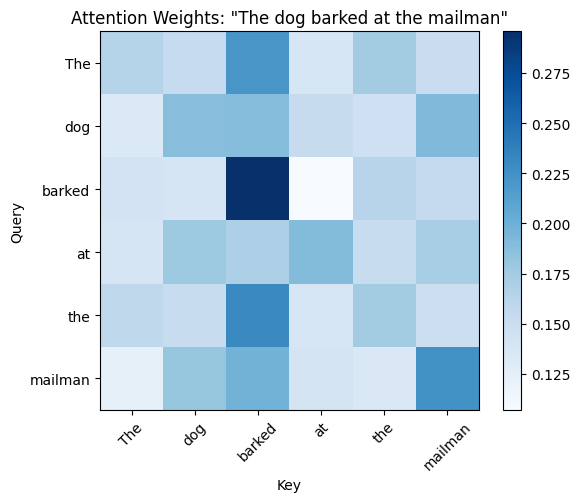

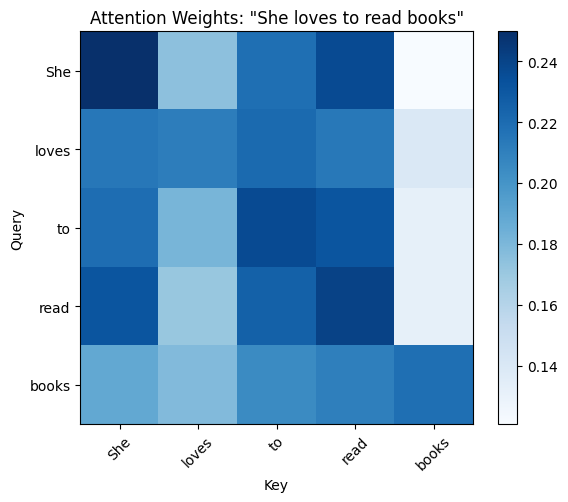

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#self-attention
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def self_attention(Q, K, V):
    d_k = Q.shape[-1]
    scores = np.dot(Q, K.T) / np.sqrt(d_k)
    weights = softmax(scores)
    output = np.dot(weights, V)
    return output, weights


sentences = [
    "The cat sat on the mat",
    "The dog barked at the mailman",
    "She loves to read books",
    "He is learning deep learning",
    "I enjoy playing the piano",
    "Transformers understand context well",
    "Attention is all you need",
    "The movie was surprisingly good",
    "He didn’t go to school because he was sick",
    "The food was so delicious that we ordered more"
]

np.random.seed(42)
embedding_dim = 6

def process_sentence(sentence):
    tokens = sentence.split()
    embeddings = np.random.rand(len(tokens), embedding_dim)
    output, attn_weights = self_attention(embeddings, embeddings, embeddings)
    return tokens, attn_weights

def visualize_attention(tokens, weights, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(weights, cmap='Blues')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=45)
    plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
    plt.title(title)
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.tight_layout()
    plt.show()


for i in range(3):
    tokens, attn = process_sentence(sentences[i])
    visualize_attention(tokens, attn, f"Attention Weights: \"{sentences[i]}\"")


# TASK 3: Introduction to Transformer Architecture


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

vocab_size = 10000
maxlen = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    pos_encoding = np.zeros_like(angle_rads)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)


def scaled_dot_product_attention(Q, K, V, mask=None):
    matmul_qk = tf.matmul(Q, K, transpose_b=True)
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scores = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scores += (mask * -1e9)

    attention_weights = tf.nn.softmax(scores, axis=-1)
    output = tf.matmul(attention_weights, V)
    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.Wq = layers.Dense(d_model)
        self.Wk = layers.Dense(d_model)
        self.Wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        Q = self.Wq(q)
        K = self.Wk(k)
        V = self.Wv(v)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(Q, K, V, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.num_heads * self.depth))

        return self.dense(concat_attention)


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])



class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        attn_output = self.mha(x, x, x, mask)
        out1 = self.layernorm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))


def build_transformer_classifier(vocab_size, maxlen, d_model=64, num_heads=4, dff=128, num_layers=2):
    inputs = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab_size, d_model)(inputs)
    x += get_positional_encoding(maxlen, d_model)

    for _ in range(num_layers):
        x = EncoderLayer(d_model, num_heads, dff)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model




In [5]:
model = build_transformer_classifier(vocab_size=vocab_size, maxlen=maxlen)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=128,
                    validation_split=0.2, verbose=1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.4945 - loss: 0.7140 - val_accuracy: 0.5062 - val_loss: 0.6927
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5030 - loss: 0.6951 - val_accuracy: 0.7236 - val_loss: 0.5922
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7845 - loss: 0.4673 - val_accuracy: 0.8592 - val_loss: 0.3248
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9072 - loss: 0.2427 - val_accuracy: 0.8780 - val_loss: 0.2918
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9445 - loss: 0.1588 - val_accuracy: 0.8740 - val_loss: 0.3328
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8694 - loss: 0.3443
Test Accuracy: 0.8694


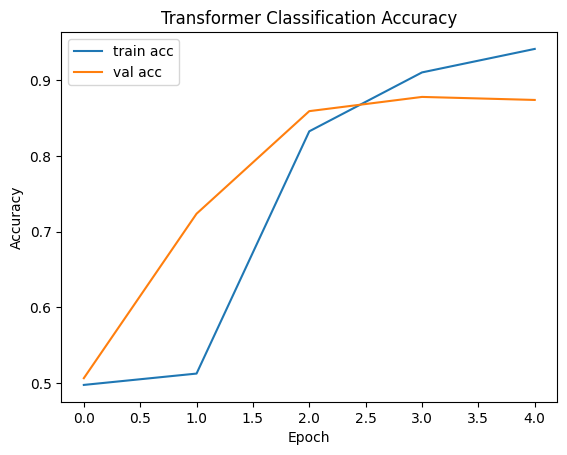

In [6]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Transformer Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
